In [ ]:
!pip install pygeos fiona shapely pyproj rtree
!pip install geopandas

In [ ]:
import pandas as pd
import geopandas as gpd

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.colors import TwoSlopeNorm

from geopandas import GeoDataFrame


In [ ]:
demographics_age_of_inhabitants_df = pd.read_csv('/content/demographics_age_of_inhabitants.csv')
demographics_background_of_inhabitants_df = pd.read_csv('/content/demographics_background_of_inhabitants.csv')
estimated_parking_spots_kfz = gpd.read_file('/content/estimated_parking_spots_kfz.geojson')
lor_friedrichshain_kreuzberg_geo = gpd.read_file('/content/lor_friedrichshain_kreuzberg.geojson')

Text(0.5, 1.0, 'parking spot distribution')

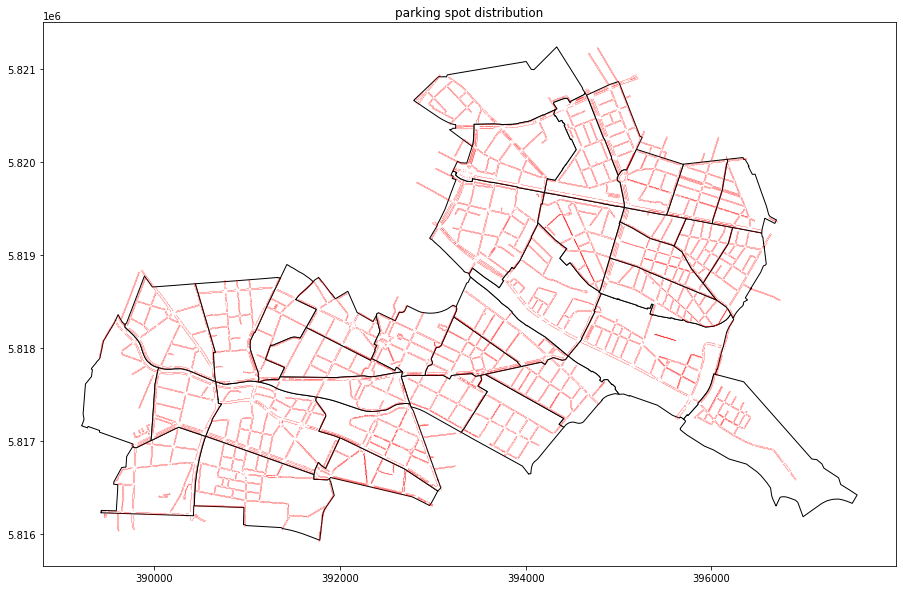

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
lor_friedrichshain_kreuzberg_geo.plot(ax = ax, color='white', edgecolor='black')
estimated_parking_spots_kfz.plot(ax=ax, marker='.', color='red', markersize=0.01)
ax.set_title('parking spot distribution')

In [ ]:
join_lor_and_parking_space = gpd.sjoin(lor_friedrichshain_kreuzberg_geo,estimated_parking_spots_kfz,how="inner", predicate='intersects')

join_lor_and_parking_space['count'] = join_lor_and_parking_space['PLR_NAME'].map(join_lor_and_parking_space['PLR_NAME'].value_counts())

sum_of_parking_spots = join_lor_and_parking_space[['PLR_NAME','count']].set_index('PLR_NAME').groupby('PLR_NAME').nth(1)
sum_of_parking_spots.head()

,count
PLR_NAME,
Am Berlin Museum,983
Andreasviertel,3542
Askanischer Platz,2297
Barnimkiez,1397
Boxhagener Platz,1663


In [ ]:
first_lor_and_id = join_lor_and_parking_space[['PLR_NAME', 'geometry']].groupby('PLR_NAME').nth(1)
first_lor_and_id.head()

,geometry
PLR_NAME,
Am Berlin Museum,"POLYGON ((391358.488 5818754.742, 391356.091 5..."
Andreasviertel,"POLYGON ((393390.983 5818796.485, 393427.343 5..."
Askanischer Platz,"POLYGON ((389805.197 5818103.272, 389818.697 5..."
Barnimkiez,"POLYGON ((392793.702 5820666.935, 392796.555 5..."
Boxhagener Platz,"POLYGON ((394906.121 5818970.485, 394952.548 5..."


In [ ]:
joined_name_geometry_parking = first_lor_and_id.join(sum_of_parking_spots)
joined_name_geometry_parking.head()

,geometry,count
PLR_NAME,,
Am Berlin Museum,"POLYGON ((391358.488 5818754.742, 391356.091 5...",983
Andreasviertel,"POLYGON ((393390.983 5818796.485, 393427.343 5...",3542
Askanischer Platz,"POLYGON ((389805.197 5818103.272, 389818.697 5...",2297
Barnimkiez,"POLYGON ((392793.702 5820666.935, 392796.555 5...",1397
Boxhagener Platz,"POLYGON ((394906.121 5818970.485, 394952.548 5...",1663


In [ ]:
joined_name_geometry_parking.index.rename('lor', inplace=True)
joined_name_geometry_parking.rename(columns={'count':'parking_count'}, inplace=True)

age_df = demographics_age_of_inhabitants_df.drop('lor_number', axis=1).set_index('lor')
background_df = demographics_background_of_inhabitants_df.set_index('lor')
age_backgroud_df = pd.merge(age_df, background_df, left_index=True, right_index=True)
age_backgroud_parking_df = pd.merge(age_backgroud_df, joined_name_geometry_parking, left_index=True, right_index=True)

### Repair Data (, to .)



In [ ]:
def convert_string_to_float_inplace(colname: str):
  age_backgroud_parking_df.loc[:, colname] = age_backgroud_parking_df[colname].apply(lambda x: x.replace(',','.')).apply(lambda x: float(x) if x == x else "")

convert_string_to_float_inplace('of_those_with_migration_background in percent (%)')
convert_string_to_float_inplace('of_German_heritage_in_percent(%)')
convert_string_to_float_inplace('germans_without_migration_background_in_percent (%)')
convert_string_to_float_inplace('germans_with_a_migration_background_in_percent (%)')
convert_string_to_float_inplace('number_of_non-Germans_in_percent(%)')

def convert_string_to_int_inplace(colname: str):
  age_backgroud_parking_df.loc[:, colname] = age_backgroud_parking_df[colname].apply(lambda x: x.replace(' ','') if isinstance(x,str) else x).apply(lambda x: int(x))

convert_string_to_int_inplace('total')
convert_string_to_int_inplace('below age 6')
convert_string_to_int_inplace('15 - 18')
convert_string_to_int_inplace('18 - 27')
convert_string_to_int_inplace('27 - 45')
convert_string_to_int_inplace('45 - 55')
convert_string_to_int_inplace('55 - 65')
convert_string_to_int_inplace('65 an more')
convert_string_to_int_inplace('of those female')
convert_string_to_int_inplace('of those immigrants')
convert_string_to_int_inplace('total_of_inhabitants')

In [ ]:
age_backgroud_parking_df['of those male'] = age_backgroud_parking_df['total'] - age_backgroud_parking_df['of those female']


In [ ]:

age_backgroud_parking_gdf = GeoDataFrame(age_backgroud_parking_df)

age_backgroud_parking_gdf.iloc[0]

total                                                                                               6257
below age 6                                                                                          368
 6 - 15                                                                                              508
15 - 18                                                                                              172
18 - 27                                                                                              834
27 - 45                                                                                             2309
45 - 55                                                                                              793
55 - 65                                                                                              629
65 an more                                                                                           644
of those female                                        

In [ ]:
def plot_percent_by_lor_with_parking_spots(cmap:str, col:str, title:str):
  
  cmap = 'Greens'
  norm1 = TwoSlopeNorm(vmin=0, vcenter=1500, vmax=4000)
  norm2 = TwoSlopeNorm(vmin= 0, vcenter=50, vmax=100)

  #f, axes = plt.subplots(figsize=(20, 10) , nrows=1,ncols=2)

  fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
  
  ax1 = age_backgroud_parking_gdf.plot(column='parking_count', cmap=cmap, legend=True, norm=norm1, ax=ax1)
  ax1.set_title('parking spot density')

  ax2 = age_backgroud_parking_gdf.plot(column=col, cmap=cmap, legend=True, norm=norm2, ax=ax2)
  ax2.set_title(title)

# Parking and migration

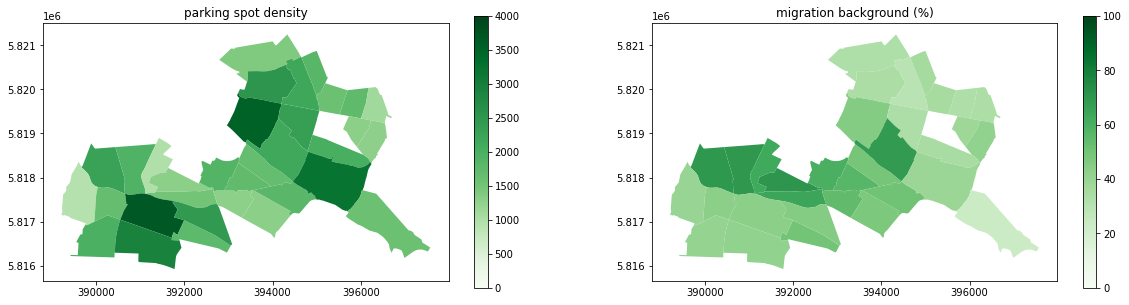

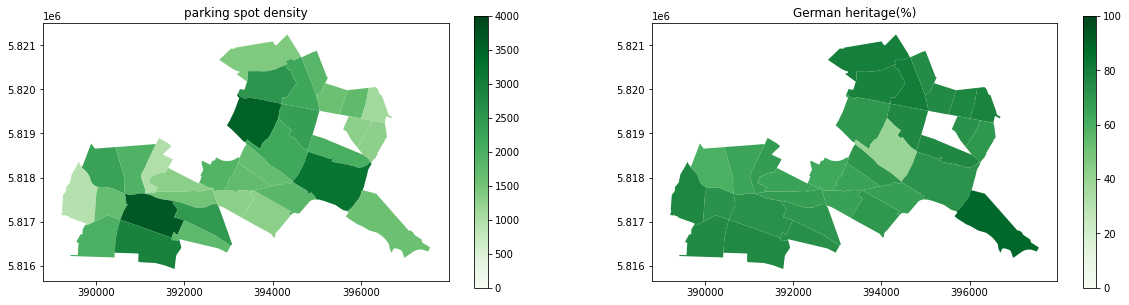

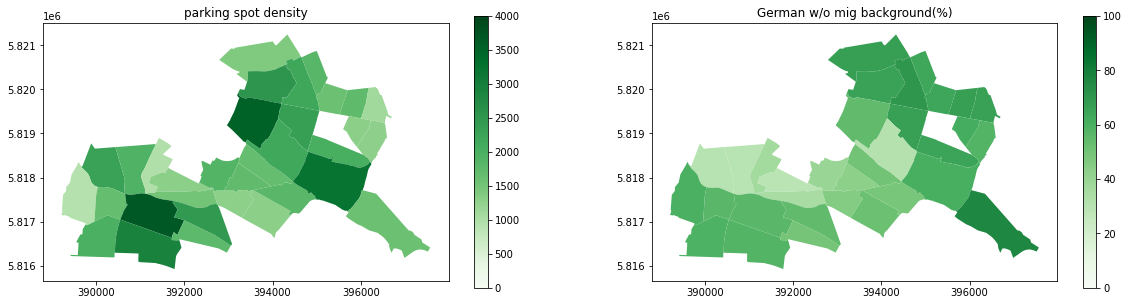

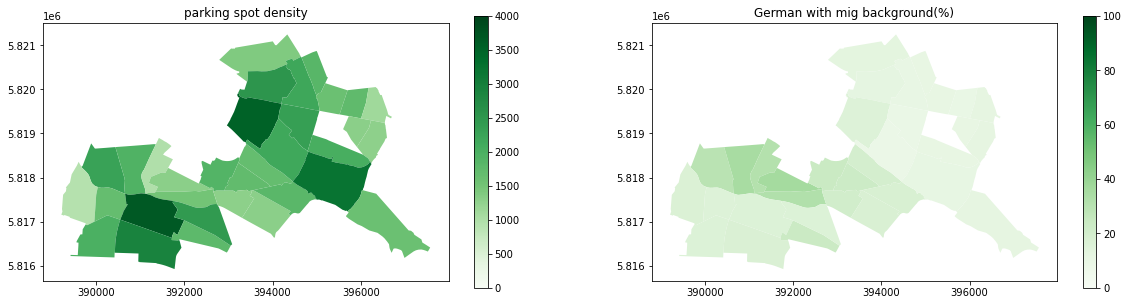

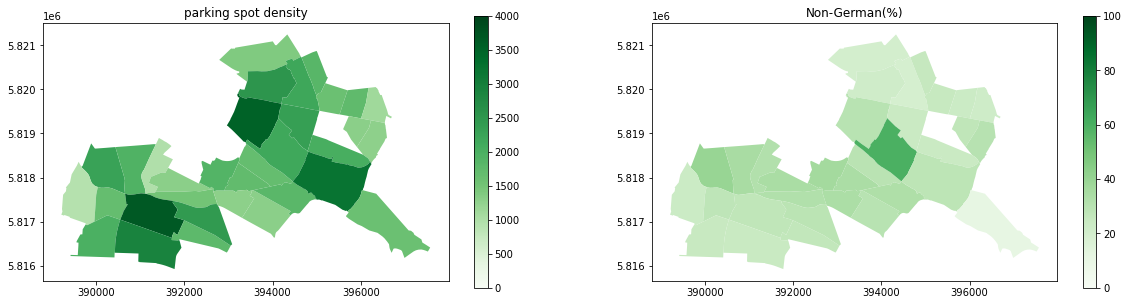

In [ ]:
plot_percent_by_lor_with_parking_spots('Greens', 'of_those_with_migration_background in percent (%)', 'migration background (%)')
plot_percent_by_lor_with_parking_spots('Greens', 'of_German_heritage_in_percent(%)', 'German heritage(%)')
plot_percent_by_lor_with_parking_spots('Greens', 'germans_without_migration_background_in_percent (%)', 'German w/o mig background(%)')
plot_percent_by_lor_with_parking_spots('Greens', 'germans_with_a_migration_background_in_percent (%)', 'German with mig background(%)')
plot_percent_by_lor_with_parking_spots('Greens', 'number_of_non-Germans_in_percent(%)', 'Non-German(%)')

In [ ]:
# age_backgroud_parking_gdf.iloc[11]

In [ ]:
def plot_norm_by_lor_with_parking_spots(cmap:str, col:str, title:str, norm):
  
  cmap = 'Greens'
  norm1 = TwoSlopeNorm(vmin=0, vcenter=1500, vmax=4000)
  norm2 = norm

  fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
  
  ax1 = age_backgroud_parking_gdf.plot(column='parking_count', cmap=cmap, legend=True, norm=norm1, ax=ax1)
  ax1.set_title('parking spot density')

  ax2 = age_backgroud_parking_gdf.plot(column=col, cmap=cmap, legend=True, norm=norm2, ax=ax2)
  ax2.set_title(title)

# Parking vs genders male and female

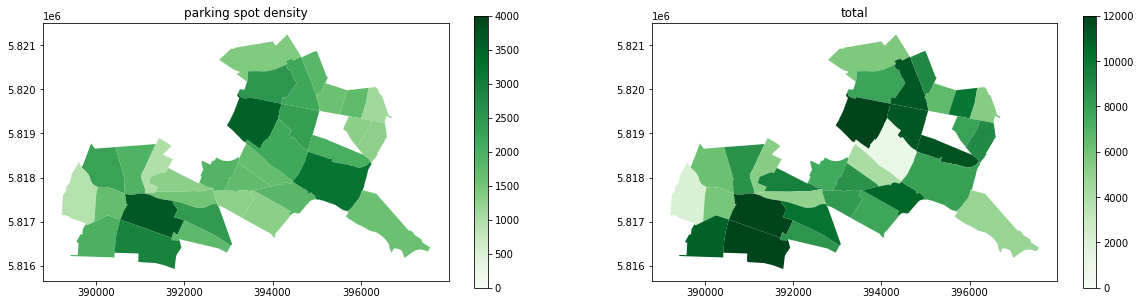

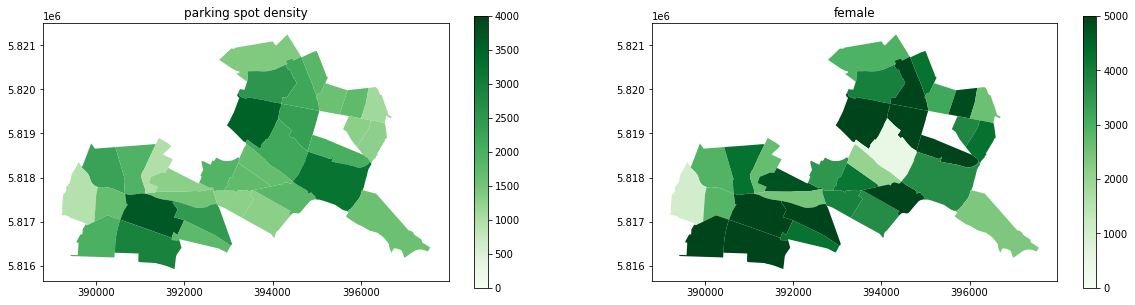

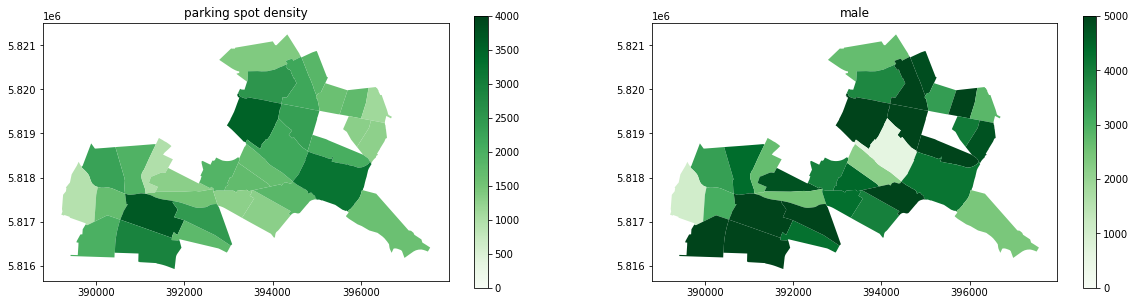

In [ ]:
plot_norm_by_lor_with_parking_spots('Greens', 'total', 'total', TwoSlopeNorm(vmin=0, vcenter=6000, vmax=12000))
plot_norm_by_lor_with_parking_spots('Greens', 'of those female', 'female', TwoSlopeNorm(vmin=0, vcenter=2500, vmax=5000))
plot_norm_by_lor_with_parking_spots('Greens', 'of those male', 'male', TwoSlopeNorm(vmin=0, vcenter=2500, vmax=5000))

# Parking vs demographic

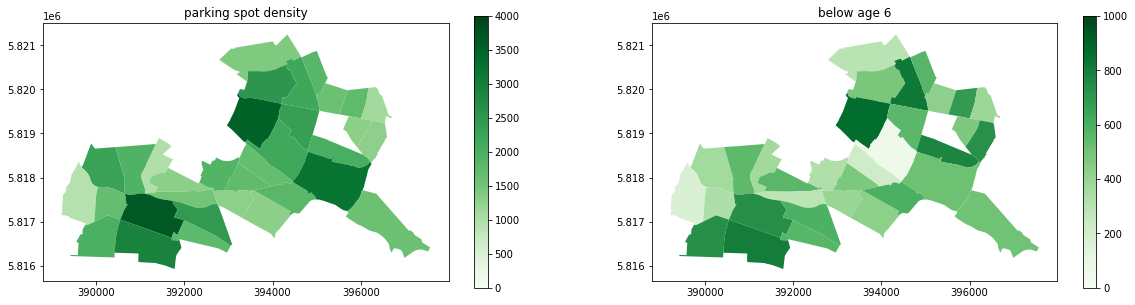

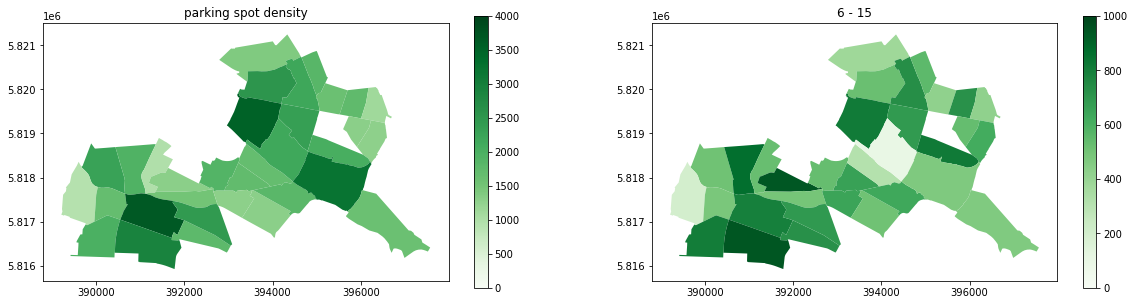

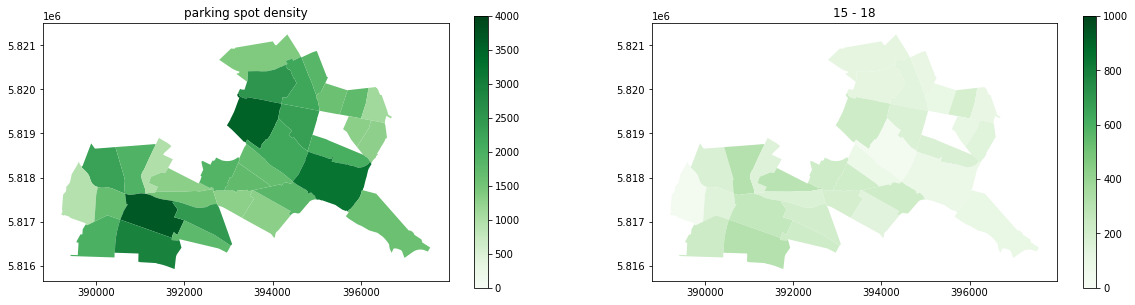

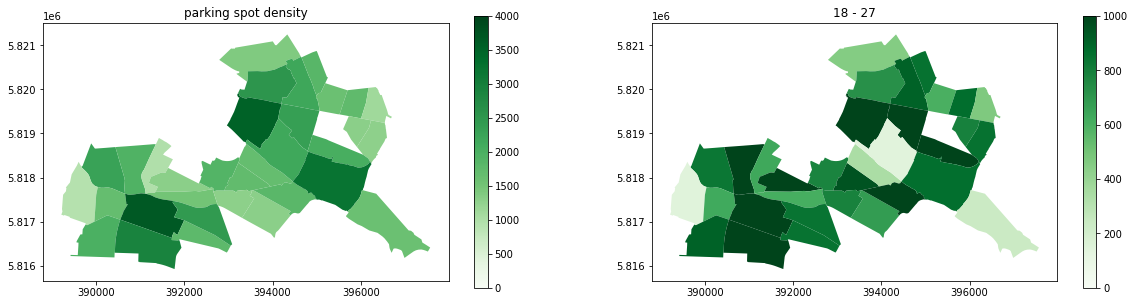

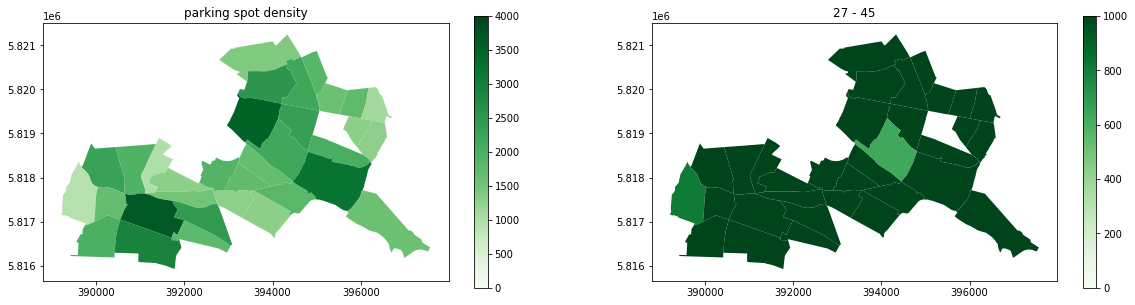

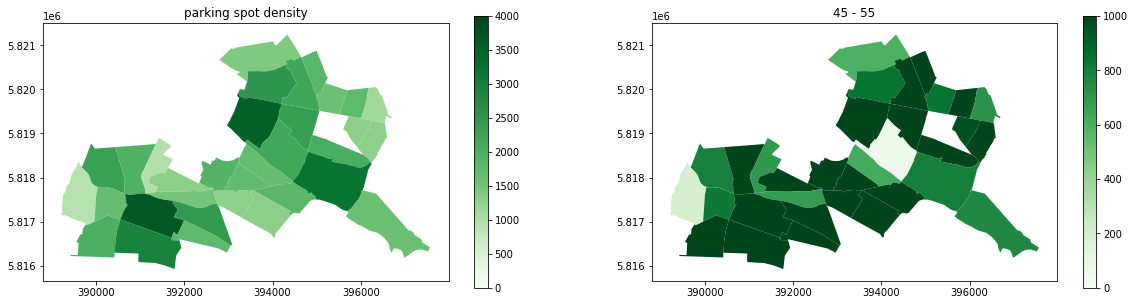

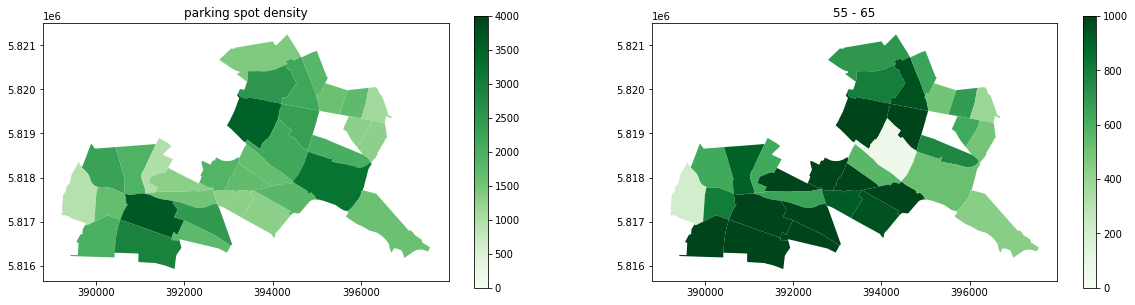

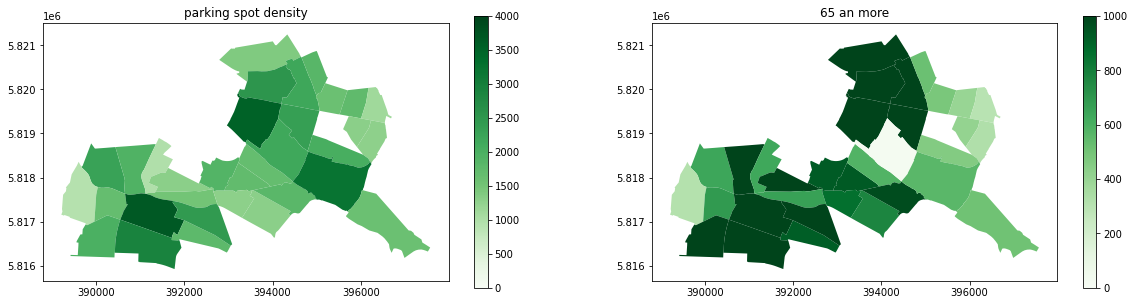

In [ ]:
plot_norm_by_lor_with_parking_spots('Greens', 'below age 6', 'below age 6', TwoSlopeNorm(vmin=0, vcenter=500, vmax=1000))
plot_norm_by_lor_with_parking_spots('Greens', ' 6 - 15', '6 - 15', TwoSlopeNorm(vmin=0, vcenter=500, vmax=1000))
plot_norm_by_lor_with_parking_spots('Greens', '15 - 18', '15 - 18', TwoSlopeNorm(vmin=0, vcenter=500, vmax=1000))
plot_norm_by_lor_with_parking_spots('Greens', '18 - 27', '18 - 27', TwoSlopeNorm(vmin=0, vcenter=500, vmax=1000))
plot_norm_by_lor_with_parking_spots('Greens', '27 - 45', '27 - 45', TwoSlopeNorm(vmin=0, vcenter=500, vmax=1000))
plot_norm_by_lor_with_parking_spots('Greens', '45 - 55', '45 - 55', TwoSlopeNorm(vmin=0, vcenter=500, vmax=1000))
plot_norm_by_lor_with_parking_spots('Greens', '55 - 65', '55 - 65', TwoSlopeNorm(vmin=0, vcenter=500, vmax=1000))
plot_norm_by_lor_with_parking_spots('Greens', '65 an more', '65 an more', TwoSlopeNorm(vmin=0, vcenter=500, vmax=1000))